# TP4: Clase 5

Para las imágenes suministradas:

In [88]:
# Se importan las librerias a utilizar
import os
import sys
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
import pandas as pd

In [89]:
# Imprimir imagenes en fila
def plot_images_row(imgs, cmap=None):
    _, axs = plt.subplots(1, len(imgs), figsize=(14, 14))
    for i, ax in enumerate(axs):
        ax.imshow(imgs[i], cmap)
        ax.set_title(str(i))
    plt.show()
    

In [90]:
# Se convierte a escala de grises
def convert_gray(img):
    return cv.cvtColor(img, cv.COLOR_BGR2GRAY)

In [91]:
# Convertir imagenes de BGR a RGB
def convert_RGB(img):
    return cv.cvtColor(img, cv.COLOR_BGR2RGB)

1 - Implementar un extractor de características LBP básico (sin uniformidad, 8 vecinos)

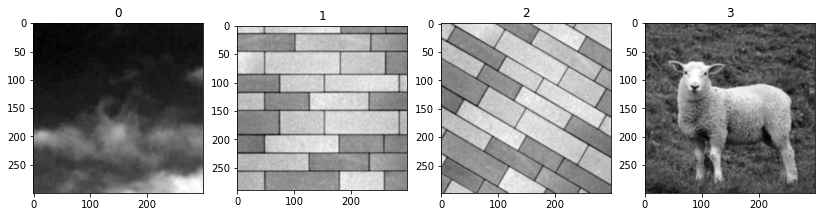

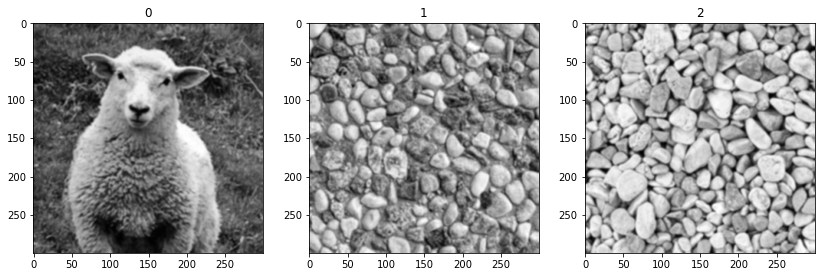

In [92]:
# Se cargan las imagenes
images_names = [
    "cielo",
    "ladrillos1",
    "ladrillos2",
    "oveja1",
    "oveja2",
    "piedras1",
    "piedras2",
]

imgs = [cv.imread(f'tp4_images/{name}.png') for name in images_names]
imgs = [convert_gray(img) for img in imgs]

# Se filtran las imagenes
imgs = [cv.GaussianBlur(img, ksize=(5, 5), sigmaX=0) for img in imgs]

plot_images_row(imgs[:4], cmap="gray")
plot_images_row(imgs[4:], cmap="gray")

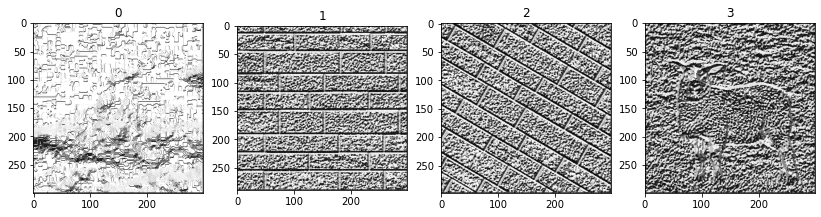

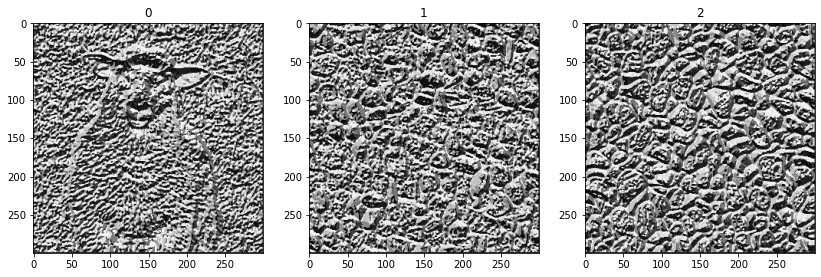

In [93]:
# Se implementa un extractor de características LBP con 8 puntos
radius = 1
n_points = 8 * radius
imgs_lbp = [local_binary_pattern(img, n_points, radius).astype(np.uint8) for img in imgs]

plot_images_row(imgs_lbp[:4], cmap="gray")
plot_images_row(imgs_lbp[4:], cmap="gray")

2 - Realizar el histograma de características LBP de la imagen

In [94]:
# Se calculan los histogramas
bin_size = 5
bins = [bin_size * i for i in range(int(255 / bin_size) + 1)]
lbp_hists = [np.histogram(img, density=True, bins=bins) for img in imgs_lbp]

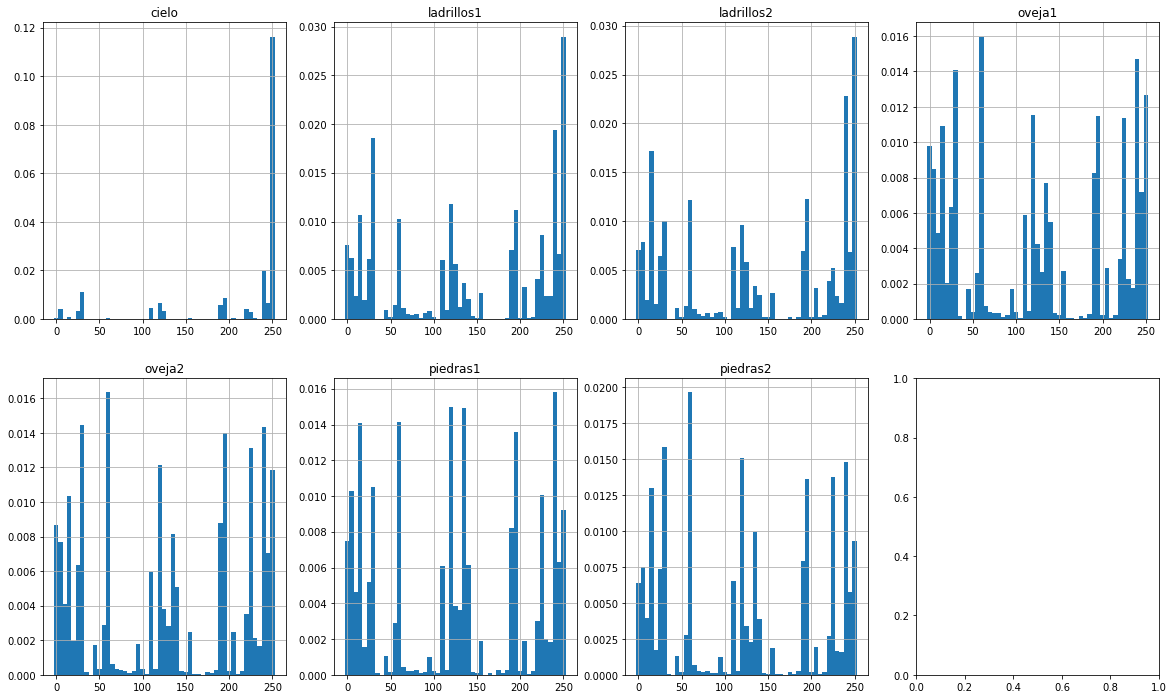

In [95]:
counter = 0
row = 2
fig, axs = plt.subplots(2, int(len(imgs) / 2) + 1, figsize=(20, 12))
for i, row in enumerate(axs):
    for j, ax in enumerate(row):
        ax.bar(lbp_hists[counter][1][:-1], lbp_hists[counter][0], width=bin_size)
        ax.set_title(images_names[counter])
        ax.grid()
        counter += 1
        if counter == len(images_names):
            break

3 - Comparar los histogramas

Primero se comparan los histogramas utilizando el método de kullback leiber

In [96]:
# Se utiliza la divergencia de kullback leibler divergence
def kullback_leibler_divergence(p, q):
    p = np.asarray(p)
    q = np.asarray(q)
    filt = np.logical_and(p != 0, q != 0)
    return np.sum(p[filt] * np.log2(p[filt] / q[filt]))

# Se obtiene un dicciorio de cada imagen con su histograma
hist_dict = zip(images_names, lbp_hists)
hist_dict = dict(hist_dict)

# Se obtiene la divergencia de kullback leibler
# y se obtiene el histograma con mayor similitud
# Se imprime el histograma más cercano
score_table = []
for name, hist in hist_dict.items():
    score = float("inf")
    score_table_row = []
    match_name = None
    for name_comp, hist_comp in hist_dict.items():
        if name != name_comp:
            kull_score = kullback_leibler_divergence(hist[0], hist_comp[0])
            if score > kull_score:
                match_name = name_comp
                score = kull_score
            score_table_row.append(kull_score)
        else:
            score_table_row.append(0)
    score_table.append(score_table_row)
    print(f"{name} -> closer to: {match_name}")

# Se imprime la tabla de resultados
scores_df = pd.DataFrame(score_table, columns=images_names, index=images_names)
scores_df


cielo -> closer to: ladrillos1
ladrillos1 -> closer to: ladrillos2
ladrillos2 -> closer to: ladrillos1
oveja1 -> closer to: oveja2
oveja2 -> closer to: oveja1
piedras1 -> closer to: piedras2
piedras2 -> closer to: oveja2


,cielo,ladrillos1,ladrillos2,oveja1,oveja2,piedras1,piedras2
cielo,0.000000,0.187263,0.192679,0.334841,0.344065,0.389990,0.384365
ladrillos1,0.206694,0.000000,0.010209,0.025311,0.028793,0.047710,0.039534
ladrillos2,0.235116,0.009744,0.000000,0.031758,0.036783,0.047269,0.046146
oveja1,0.326556,0.025237,0.032033,0.000000,0.001338,0.009851,0.007780
oveja2,0.328577,0.027690,0.036508,0.001330,0.000000,0.008895,0.004549
piedras1,0.380028,0.048309,0.049235,0.010228,0.009291,0.000000,0.008392
piedras2,0.353884,0.036018,0.044162,0.007331,0.004402,0.008441,0.000000


Se hace un análisis similar utilizando los métodos de comparación de histogramas de openCV. Se utilizan distintos métodos de comparación.

In [97]:
# Se calculan los histogramas utilizando openCV
bin_size = 5
bins = [bin_size * i for i in range(int(255 / bin_size) + 1)]
lbp_hists = [cv.calcHist([img], [0], None, [bin_size], [0, 256]) for img in imgs_lbp]

In [98]:
# Se comparan los histogramas utilizando cv.compareHist()
hist_dict = zip(images_names, lbp_hists)
hist_dict = dict(hist_dict)
score_table = []

# Se definen distintos métodos de comparación
cv_methods = {
    "CORREL": cv.HISTCMP_CORREL, 
    "CHISQR": cv.HISTCMP_CHISQR, 
    "BHATTACHARYYA": cv.HISTCMP_BHATTACHARYYA,
}

# Se obtiene el hitograma más cercano a cada histograma.
for name, method in cv_methods.items():
    print(f"\n{name}:")
    for name, hist in hist_dict.items():
        score = float("inf")
        score_table_row = []
        match_name = None
        for name_comp, hist_comp in hist_dict.items():
            if name != name_comp:
                imgs_score = cv.compareHist(hist, hist_comp, method)
                if score > imgs_score:
                    match_name = name_comp
                    score = imgs_score
                score_table_row.append(imgs_score)
            else:
                score_table_row.append(0)
        score_table.append(score_table_row)
        print(f"{name} -> closer to: {match_name}")



CORREL:
cielo -> closer to: piedras1
ladrillos1 -> closer to: piedras1
ladrillos2 -> closer to: piedras1
oveja1 -> closer to: cielo
oveja2 -> closer to: cielo
piedras1 -> closer to: cielo
piedras2 -> closer to: cielo

CHISQR:
cielo -> closer to: ladrillos1
ladrillos1 -> closer to: ladrillos2
ladrillos2 -> closer to: ladrillos1
oveja1 -> closer to: oveja2
oveja2 -> closer to: oveja1
piedras1 -> closer to: piedras2
piedras2 -> closer to: oveja1

BHATTACHARYYA:
cielo -> closer to: ladrillos1
ladrillos1 -> closer to: ladrillos2
ladrillos2 -> closer to: ladrillos1
oveja1 -> closer to: oveja2
oveja2 -> closer to: oveja1
piedras1 -> closer to: piedras2
piedras2 -> closer to: oveja1
